In [6]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import robust_scale
from sqlalchemy import create_engine

In [7]:
from castor import spec2sqr, SPECDIR

In [8]:
from ipywidgets import IntProgress
from IPython.display import display

In [21]:
%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["image.cmap"] = "jet"

## Data

In [10]:
eng = create_engine("sqlite:///pollux.db")

In [11]:
key = ["Teff", "logg", "metallic"]

In [12]:
data = pd.read_sql("SELECT basename, {} FROM flat WHERE lambda_max = 12000".format(",".join(key)), eng)

In [13]:
data.replace(-99.0, np.nan, inplace=True)
data.dropna(inplace=True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8035 entries, 0 to 8034
Data columns (total 4 columns):
basename    8035 non-null object
Teff        8035 non-null float64
logg        8035 non-null float64
metallic    8035 non-null float64
dtypes: float64(3), object(1)
memory usage: 313.9+ KB


In [16]:
filename = data["basename"].iloc[0]
wave, flux, norm = np.loadtxt(SPECDIR+filename+".gz", usecols=(0,1,2), unpack=True)

## Input

In [17]:
with open("pollux.lst", "w") as fl:
    for name in data["basename"]:
        fl.write(name.strip(".fits\n")+"\n")

## Output

In [18]:
np.save("pollux.npy", data[key])

### Hair cut 

In [19]:
wi = 3700 < wave 
wf = wave < 9100
ww =   wi * wf

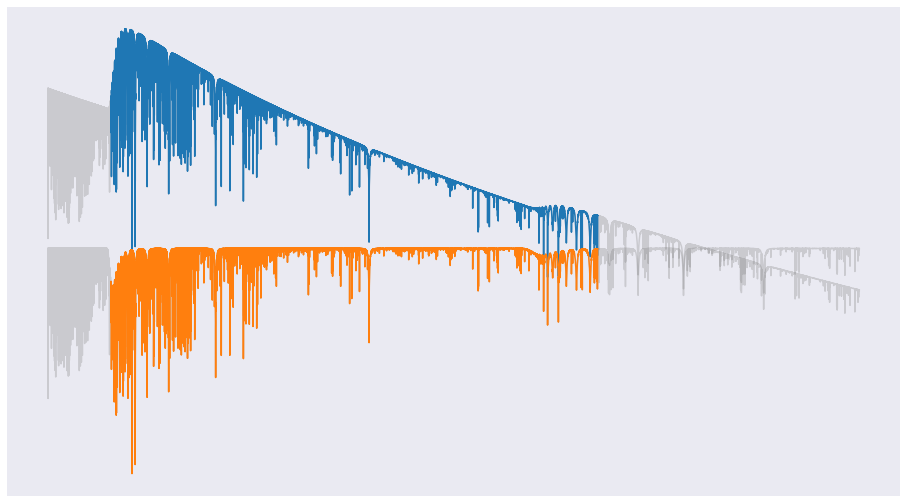

In [22]:
plt.yscale("log")
plt.xticks([]); plt.yticks([])
plt.plot(wave, flux, color="gray", alpha=0.3)
plt.plot(wave, norm*1e7, color="gray", alpha=0.3)
plt.plot(wave[ww], flux[ww])
plt.plot(wave[ww], norm[ww]*1e7)

### Minecraft

In [23]:
sqr = spec2sqr(flux[ww])

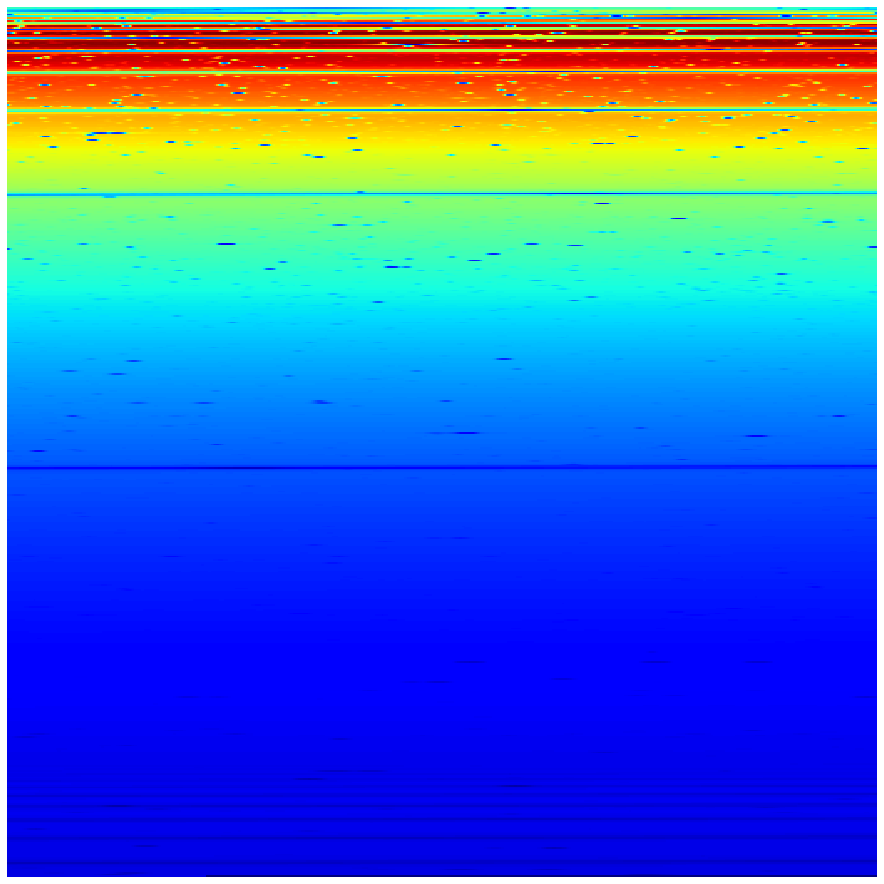

In [24]:
plt.figure(figsize=(16,16))
plt.xticks([]); plt.yticks([])
plt.imshow(sqr);

### Binning & Renormalizace

In [25]:
sub = np.copy(flux[ww])
sub.resize(4000, 69)
sup = sub.sum(axis=1).reshape(-1, 1)
sqr = spec2sqr(robust_scale(sup), a=62)

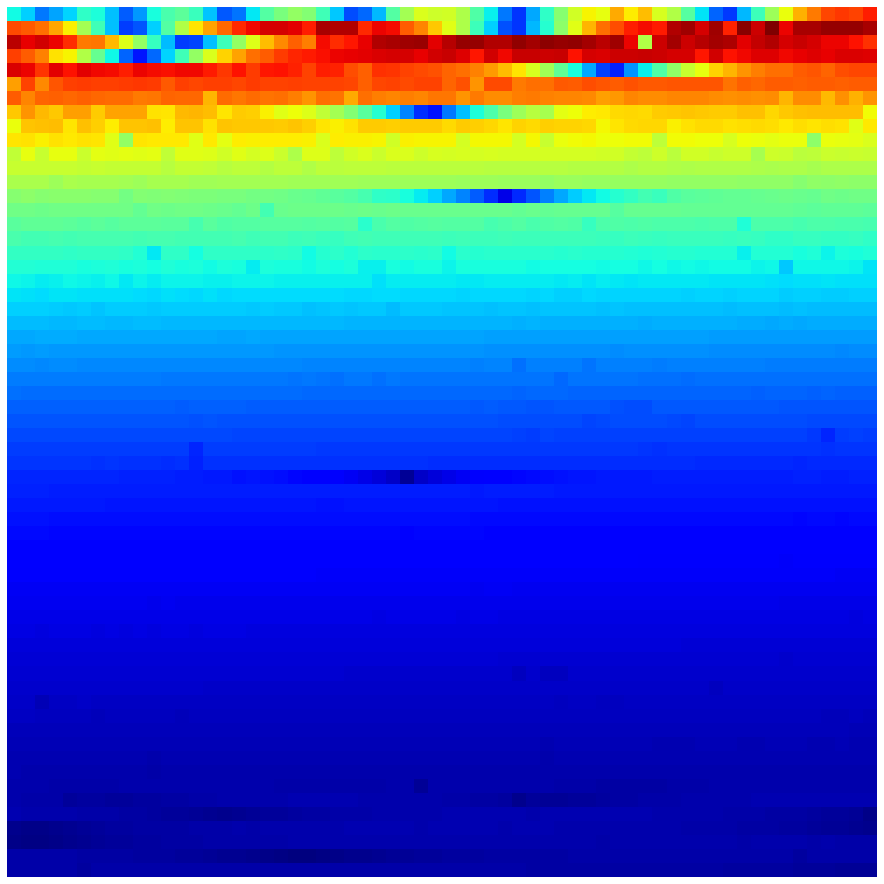

In [26]:
plt.figure(figsize=(16,16))
plt.xticks([]); plt.yticks([])
plt.imshow(sqr)

## Sampling POLLUX down to LAMOST...

```python
prog = IntProgress(min=0, max=len(data))
display(prog)
for filename in data["basename"]:
# if not os.path.exists("pollux/"+filename+".npy"):
    flux = np.loadtxt(SPECDIR+filename+".gz",
                      usecols=[1], # <-!-!-!-<<<
                      unpack=True)
    sub = np.copy(flux[ww])
    sub.resize(4000, 69)  ## binning
    sup = sub.sum(axis=1).reshape(-1, 1)
    sqr = spec2sqr(robust_scale(sup), a=62)  ## normalizace
    np.save("pollux/"+filename+".npy", sqr)
    prog.value += 1
```